# Visual Wake Words (VWW) Project - Phase 1
**Goal:** Load dataset, preprocess data, and define baseline models for comparison.
**Environment:** Google Colab / TensorFlow 2.x

## 1. Setup & Imports

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os

# Check GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: False


## 2. Data Loading
**Note:** The standard `visual_wake_words` in TFDS requires manually downloading the 20GB+ COCO dataset, which is often impractical for quick experiments.

**Strategy:**
1.  We check for a local dataset folder `vww_dataset/`.
2.  If not found, we generate **Dummy Data** (random noise) so you can run the rest of the notebook to verify the model architecture.
3.  **Action Required:** To train a real model, download a "Person Detection" dataset (e.g. from Kaggle) and extract it to `vww_dataset/` with subfolders `train/person`, `train/not_person`, etc.

In [8]:
# Define parameters here so they are available for loading
IMG_SIZE = 96
BATCH_SIZE = 32

import pathlib
import shutil
import numpy as np

# Strategy: Try to load from local directory first. 
# If not found, generate DUMMY data so you can verify the model structure immediately.
# NOTE: 'visual_wake_words' in TFDS requires manual COCO download (20GB+), which is prone to failure.

# Define path for local dataset
dataset_dir = pathlib.Path('vww_dataset')

# --- DUMMY DATA GENERATION (For Testing Pipeline) ---
if not dataset_dir.exists():
    print("⚠️ Real dataset not found. Generating DUMMY data for testing...")
    print("TODO: Download a real VWW dataset (e.g. from Kaggle) and extract it to 'vww_dataset/'")
    
    # Create dummy structure: vww_dataset/train/person, vww_dataset/train/not_person
    for split in ['train', 'validation']:
        for label in ['person', 'not_person']:
            path = dataset_dir / split / label
            path.mkdir(parents=True, exist_ok=True)
            # Create 10 random images per class
            for i in range(10):
                img = np.random.randint(0, 255, (96, 96, 3), dtype=np.uint8)
                tf.keras.utils.save_img(path / f'img_{i}.jpg', img)
    print("✅ Dummy data generated.")

# --- DATA LOADING ---
print(f"Loading data from: {dataset_dir}")

# image_dataset_from_directory ALREADY batches the data by default (batch_size=32)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir / 'train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir / 'validation',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Helper to get info similar to tfds (for compatibility with visualization code)
class LabelFeature:
    def __init__(self, names):
        self.names = names
    def int2str(self, x):
        return self.names[x]

class Info:
    features = {'label': LabelFeature(class_names)}

info = Info()

Loading data from: vww_dataset
Found 20 files belonging to 2 classes.
Found 20 files belonging to 2 classes.
Class names: ['not_person', 'person']
Found 20 files belonging to 2 classes.
Class names: ['not_person', 'person']


## 3. Preprocessing
*   **Resize:** 96x96 (Standard for TinyML VWW).
*   **Normalization:** Scale pixel values to [-1, 1] (Expected by MobileNet).
*   **Augmentation:** Random flip/rotation (Optional for training).

In [9]:
IMG_SIZE = 96
# BATCH_SIZE is already defined and used in Data Loading

def preprocess(image, label):
    # Resize
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Normalize to [-1, 1]
    image = (image / 127.5) - 1.0
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Prepare pipelines
AUTOTUNE = tf.data.AUTOTUNE

# Note: train_ds is ALREADY batched from image_dataset_from_directory.
# We map functions that can handle batches (or use unbatch() if needed, but resize/augment work on batches).

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
# train_ds = train_ds.batch(BATCH_SIZE) # REMOVED: Avoid double batching!
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.batch(BATCH_SIZE) # REMOVED: Avoid double batching!
val_ds = val_ds.prefetch(AUTOTUNE)

## 4. Visualization
Let's verify the data by plotting a few images from the training batch.
Note: Images are normalized to [-1, 1], so we need to rescale them to [0, 1] for display.

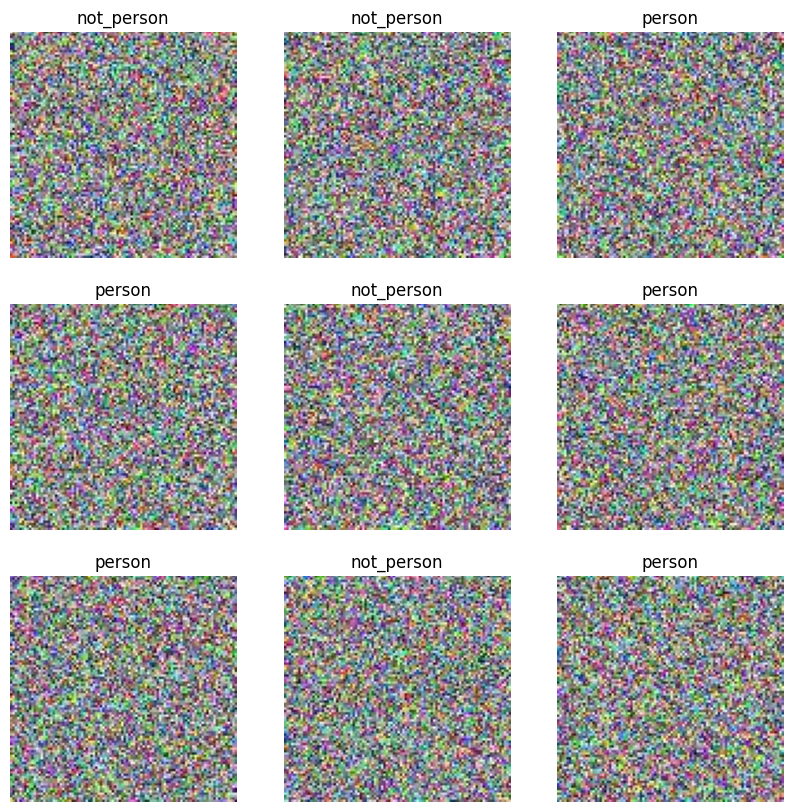

In [10]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # Rescale from [-1, 1] to [0, 1] for plotting
    img = (image_batch[i] + 1) / 2.0
    plt.imshow(img)
    label = label_batch[i].numpy()
    plt.title(info.features['label'].int2str(label))
    plt.axis("off")
plt.show()

## 5. Model Definition

### Model A: MobileNetV2 (alpha=0.35)
This is a classic choice for VWW. `alpha=0.35` reduces the width of the network, significantly reducing parameters and FLOPs.

In [11]:
def create_mobilenet_v2_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        alpha=0.35
    )
    
    # Freeze base model for initial transfer learning
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model_v2 = create_mobilenet_v2_model()
model_v2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_v2.summary()

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_96             │ (None, 3, 3, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,489 (1.57 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 410,208 (1.56 MB)

### Model B: MobileNetV3-Small
MobileNetV3 uses Neural Architecture Search (NAS) and hard-swish activation functions, often providing better accuracy-latency trade-offs than V2.

In [12]:
def create_mobilenet_v3_model():
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        minimalistic=False # Use standard V3 Small
    )
    
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model_v3 = create_mobilenet_v3_model()
model_v3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_v3.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 3, 3, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,697 (3.58 MB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 939,120 (3.58 MB)

## 6. Initial Comparison (Parameter Count)
Before training, let's compare the size of the models. This is a crucial metric for embedded deployment.

In [13]:
def get_model_params(model):
    return model.count_params()

params_v2 = get_model_params(model_v2)
params_v3 = get_model_params(model_v3)

print(f"MobileNetV2 (alpha=0.35) Parameters: {params_v2:,}")
print(f"MobileNetV3-Small Parameters:        {params_v3:,}")

if params_v2 < params_v3:
    print("MobileNetV2 is smaller.")
else:
    print("MobileNetV3-Small is smaller.")

MobileNetV2 (alpha=0.35) Parameters: 411,489
MobileNetV3-Small Parameters:        939,697
MobileNetV2 is smaller.
